# Accidents 2022 - Decision Tree

## Dictionary

In [1]:
from dictionary import dictionary 
ACCIDENT_TYPES_KEY = 'p6'

## Imports and functions

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from datetime import datetime

# Function to treat missing values
def treatMissingValues(df, column, strategy='mean', fill_value=None):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame.")
    
    df_copy = df.copy()

    if column not in df_copy.columns:
        print(f"Column '{column}' not found in the DataFrame.")
        return df_copy
    
    col_dtype = df_copy[column].dtype
    
    if df_copy[column].isnull().sum() == 0:
        print(f"No missing values found in column '{column}'.")
        return df_copy
    
    if strategy == 'mean' and col_dtype in ['int64', 'float64']:
        mean_value = df_copy[column].mean()
        fill_value = round(mean_value)
    elif strategy == 'mode':
        fill_value = df_copy[column].mode()[0]
    elif strategy == 'median' and col_dtype in ['int64', 'float64']:
        fill_value = df_copy[column].median()
    elif strategy == 'ffill':
        df_copy[column].fillna(method='ffill', inplace=True)
        return df_copy
    elif strategy == 'bfill':
        df_copy[column].fillna(method='bfill', inplace=True)
        return df_copy
    elif strategy == 'custom':
        if fill_value is None:
            print("Error: 'fill_value' must be provided when 'strategy' is 'custom'.")
            return df_copy
    else:
        print("Invalid strategy.")
        return df_copy
    
    df_copy[column].fillna(fill_value, inplace=True)
    print(f"Filled missing values in column '{column}' with {strategy}: {fill_value}")
    
    return df_copy

# Calculate age
current_year = datetime.now().year

def calculate_age(birthday_year):
    try:
        year = int(birthday_year)
        current_year_last_two_digit = current_year % 100
        # Convert to full years
        full_year = 1900 + year if year > current_year_last_two_digit else 2000 + year
        return current_year - full_year
    except (TypeError, ValueError):
        return None
    

def assign_age_group(age):
    if age <= 15:
        return 0
    elif age <= 26:
        return 1
    elif age <= 50:
        return 2
    elif age <= 65:
        return 3
    elif age <= 80:
        return 4
    else:
        return 5  
    
def translate_and_print_example(models, example):
    example_name = example.name
    translated_keys = [dictionary.get(key, {}).get('label', key) for key in example.index]
    translated_values = [dictionary.get(key, {}).get('items', {}).get(str(int(value)), value) for key, value in example.items()]
    prediction = models['p6'].predict([example]) 
    result = prediction[0]
    label = dictionary.get('p6', {}).get('items', {}).get(str(result), result)

    print(f"{example_name}: >>")
    for key, value, translated_value in zip(translated_keys, example, translated_values):
        print(f"{key}: {translated_value if translated_value != value else value}")
    print("Prediction:", label, " <<")    

## Data preprocessing
### Import accidents dataset

In [3]:
# Load accidents from CSV file
raw_data_accidents = pd.read_csv('output/00_raw.csv',delimiter=';')

# Selected columns that may affect result
data_accidents_column_names = ['p1','p2a', 'p5a', 'p6', 'p7', 'p8', 'p10','p11', 'p12','p15', 'p16', 'p17','p18', 'p19', 'p20', 'p21', 'p22', 'p23','p28', 'p36' ]
print(f"Imported {len(data_accidents_column_names)} columns:",[dictionary.get(str(column), str(column)).get('label', str(column)) for column in data_accidents_column_names])
data_accidents = raw_data_accidents.loc[:, data_accidents_column_names]

# Make sure they are unique
unique_p1_accidents = data_accidents['p1'].unique()
data_accidents = pd.merge(data_accidents, pd.DataFrame({'p1': unique_p1_accidents}), on='p1', how='inner')

# Check is unique (same rows)
assert unique_p1_accidents.shape[0] == data_accidents.shape[0], "Dataset is not unique."

print(data_accidents)
print(data_accidents.shape)

Imported 20 columns: ['id', 'Den, Mesic, Rok', 'Lokalita nehody', 'Druh nehody', 'Druh srazky jedouciho vozidel', 'Druh pevne prekazky', 'Zavineni nehody', 'Pritomnost alkoholu u vinika', 'Hlavni priciny nehody', 'Typ povrchu silnice', 'Stav povrchu vozovky v dobe nehody', 'Stav komunikace', 'Povetrnostni podminky v dobe nehody', 'Viditelnosti', 'Rozhledove podminky', 'Deleni komunikace', 'Situovani nehody na komunikaci', 'Rizeni provozu v dobe nehody', 'Smerove pomery', 'Druh pozemni komunikace']
                 p1         p2a  p5a  p6  p7  p8  p10  p11  p12  p15  p16  \
0          28224655  2022-07-18  1.0   1   3   0    1    0  502    2    1   
1          28226941  2022-08-30  1.0   1   2   0    1    0  511    2    2   
2          29220778  2022-08-09  1.0   2   0   0    1    2  504    1    1   
3          29220866  2022-08-08  1.0   0   0   0    1    0  411    2    1   
4          29222305  2022-08-27  1.0   0   0   0    1    2  504    2    1   
...             ...         ...  ..

### Import temperature dataset

In [4]:
# Load temperature from CSV file
raw_data_temperature = pd.read_csv('output/temperature.csv',delimiter=';')

# Choose columns that may affect result
data_temperature_column_names = ['p2a','teplota' ]
print(f"Imported {len(data_temperature_column_names)} columns:",[dictionary.get(column, {}).get('label') or column for column in data_temperature_column_names])
data_temperature = raw_data_temperature.loc[:, data_temperature_column_names]

# Replace commas with dot in the specified columns and convert to float
data_temperature['teplota'] = data_temperature['teplota'].str.replace(',', '.').astype(float)

print(data_temperature)

Imported 2 columns: ['Den, Mesic, Rok', 'teplota']
            p2a  teplota
0    2022-01-01     10.2
1    2022-01-02      8.2
2    2022-01-03      8.0
3    2022-01-04      7.0
4    2022-01-05      2.8
..          ...      ...
360  2022-12-27      3.4
361  2022-12-28      4.8
362  2022-12-29      9.6
363  2022-12-30      7.7
364  2022-12-31     14.7

[365 rows x 2 columns]


### Join dataset by ID

In [5]:
# Right join temperature table, we only interest in accidents with temparature
data = pd.merge(data_accidents, data_temperature, on='p2a', how='right')
total_missing_values = data.isnull().sum().sum()

print("Merged data:", data)

Merged data:                p1         p2a  p5a  p6  p7  p8  p10  p11  p12  p15  ...  p17  \
0      2100220001  2022-01-01  1.0   1   2   0    1    2  410    2  ...    1   
1      2100220002  2022-01-01  1.0   1   4   0    1    2  503    2  ...    1   
2      2100220003  2022-01-01  1.0   2   0   0    1    0  516    2  ...    1   
3      2100220004  2022-01-01  1.0   2   0   0    1    8  209    1  ...    1   
4      2100220005  2022-01-01  1.0   0   0   0    3    0  100    2  ...    1   
...           ...         ...  ...  ..  ..  ..  ...  ...  ...  ...  ...  ...   
15458  3100224508  2022-12-31  1.0   1   2   0    1    2  410    2  ...    1   
15459  3100224509  2022-12-31  1.0   1   2   0    1    6  511    2  ...    1   
15460  3100224510  2022-12-31  1.0   1   1   0    1    2  501    2  ...    1   
15461  3100224513  2022-12-31  1.0   2   0   0    1    0  516    2  ...    1   
15462  3100224514  2022-12-31  1.0   8   4   0    1    2  503    2  ...    1   

       p18  p19  p20  p21 

### Split accidents dataset

### Preprocessing training dataset

In [6]:
# drop target and datum
X = data.drop(['p1', 'p6', 'p2a'], axis=1)
y = data.loc[:, ['p6']]

# print(f"Columns:",[dictionary.get(str(column), str(column)).get('label', str(column)) for column in X])
# print(f"Target:",[dictionary.get(str(column), str(column)).get('label', str(column)) for column in y])

# Splitting the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30/70
print(f"Training data: {len(X_train)} rows")
print(f"Testing data: {len(X_test)} rows")

print(X_train)

Training data: 10824 rows
Testing data: 4639 rows
       p5a  p7  p8  p10  p11  p12  p15  p16  p17  p18  p19  p20  p21  p22  \
598    1.0   2   0    1    2  405    2    1    1    1    4    1    0    1   
4562   1.0   0   0    1    0  516    2    1    1    1    1    1    1    1   
6890   1.0   1   0    1    2  405    2    1    1    1    1    1    0    1   
8675   1.0   0   0    1    0  516    2    1    1    1    1    1    1    1   
7403   1.0   2   0    1    2  411    2    1    1    1    1    1    2    1   
...    ...  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5191   1.0   0   0    1    0  516    1    1    1    1    1    1    2    1   
13418  1.0   2   0    1    0  502    2    1    1    1    1    1    2    1   
5390   1.0   4   0    1    2  503    2    1    1    1    1    1    2    1   
860    1.0   4   0    1    2  503    2    1    1    1    1    1    0    1   
7270   1.0   3   0    1    2  405    2    1    1    1    1    1    0    1   

       p23  p28  p36  tep

In [7]:
# Check for missing values in each column
for column in X_train.columns:
    missing_values_count = X_train[column].isnull().sum()
    if missing_values_count > 0:
        default_value = dictionary.get(column,{}).get('default')
        if default_value:
            X_train = treatMissingValues(df=X_train, column=column, strategy='custom', fill_value=default_value)
        else:    
            print(f"Column '{column}' has {missing_values_count} missing value(s). There is no default value defined for '{column}'. Please provide treatment manually.")

# check missing values treatement
missing_values_per_column = X_train.isnull().any()
assert not missing_values_per_column.any(), "Columns with missing values: {missing_values_per_column[missing_values_per_column]}"
print(X_train)

Filled missing values in column 'p5a' with custom: 1
       p5a  p7  p8  p10  p11  p12  p15  p16  p17  p18  p19  p20  p21  p22  \
598    1.0   2   0    1    2  405    2    1    1    1    4    1    0    1   
4562   1.0   0   0    1    0  516    2    1    1    1    1    1    1    1   
6890   1.0   1   0    1    2  405    2    1    1    1    1    1    0    1   
8675   1.0   0   0    1    0  516    2    1    1    1    1    1    1    1   
7403   1.0   2   0    1    2  411    2    1    1    1    1    1    2    1   
...    ...  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5191   1.0   0   0    1    0  516    1    1    1    1    1    1    2    1   
13418  1.0   2   0    1    0  502    2    1    1    1    1    1    2    1   
5390   1.0   4   0    1    2  503    2    1    1    1    1    1    2    1   
860    1.0   4   0    1    2  503    2    1    1    1    1    1    0    1   
7270   1.0   3   0    1    2  405    2    1    1    1    1    1    0    1   

       p23  p28  p36  

### Preprocessing testing dataset

In [8]:
# Check for missing values in each column
for column in X_test.columns:
    missing_values_count = X_test[column].isnull().sum()
    if missing_values_count > 0:
        default_value = dictionary.get(column,{}).get('default')
        if default_value:
            X_test = treatMissingValues(df=X_test, column=column, strategy='custom', fill_value=default_value)
        else:    
            print(f"Column '{column}' has {missing_values_count} missing value(s). There is no default value defined for '{column}'. Please provide treatment manually.")
# check missing values treatement
missing_values_per_column = X_test.isnull().any()
assert not missing_values_per_column.any(), "Columns with missing values: {missing_values_per_column[missing_values_per_column]}"
print(X_test)

       p5a  p7  p8  p10  p11  p12  p15  p16  p17  p18  p19  p20  p21  p22  \
10206  1.0   3   0    1    2  408    2    1    1    1    1    1    1    1   
5657   1.0   0   0    3    2  100    2    1    1    1    1    1    1    1   
8639   1.0   0   0    1    9  511    2    1    1    1    1    1    0    1   
6685   1.0   0   9    1    0  508    2    3    1    4    1    1    1    1   
4403   1.0   0   9    0    0  100    2    1    1    1    4    1    0    0   
...    ...  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9577   1.0   0   4    1    2  204    2    3    1    3    3    1    1    1   
13167  1.0   0   0    1    0  516    2    1    1    1    1    1    1    0   
5121   1.0   0   0    1    0  516    2    3    1    1    1    1    1    1   
14312  1.0   0   9    1    2  504    2    1    1    1    1    1    1    1   
12554  1.0   0   0    1    2  502    3    1    1    1    1    1    1    1   

       p23  p28  p36  teplota  
10206    0    1    7     18.7  
5657     0 

## Decitions Tree

In [9]:
# Model loop in case to run multiple targets
models = {}

for column in y.columns:
    # run treatment if there are
    if y_train[column].isnull().sum() > 0:
        default_value = dictionary.get(column,{}).get('default')
        y_train = treatMissingValues(df=y_train, column=column, strategy='custom', fill_value=default_value)
    clf = DecisionTreeClassifier()
    print( y_train[column])
    clf.fit(X_train, y_train[column])
    models[column] = clf

# Evaluate the Model
accuracies = {}
for column in y.columns:
    y_pred = models[column].predict(X_test)
    accuracies[column] = accuracy_score(y_test[column], y_pred)
    print(f"Accuracy for {dictionary.get(column,{}).get('label')}: {accuracies[column]}")

    print(f"\nConfusion Matrix for {dictionary.get(column,{}).get('label')}:\n")
    print(confusion_matrix(y_test[column], y_pred))

    print(f"\nClassification Report for {dictionary.get(column,{}).get('label')}:\n")
    print(classification_report(y_test[column], y_pred))

598      1
4562     2
6890     1
8675     2
7403     1
        ..
5191     2
13418    1
5390     1
860      1
7270     1
Name: p6, Length: 10824, dtype: int64
Accuracy for Druh nehody: 0.9420133649493425

Confusion Matrix for Druh nehody:

[[  59    0   36    0   12    2    2    0    8]
 [   0 1916    0    0    0    0    0   20    0]
 [  36    0 1441    0   19    0    2    0   24]
 [   0    0    0  672    0    0    0    0    0]
 [   9    0   29    0   97    0    1    0    1]
 [   1    0    1    0    0   70    7    0    0]
 [   0    0    0    0    0    4    0    0    0]
 [   0   21    0    0    0    0    0   93    0]
 [  16    0   16    0    2    0    0    0   22]]

Classification Report for Druh nehody:

              precision    recall  f1-score   support

           0       0.49      0.50      0.49       119
           1       0.99      0.99      0.99      1936
           2       0.95      0.95      0.95      1522
           3       1.00      1.00      1.00       672
           4   

## Display Decision Tree

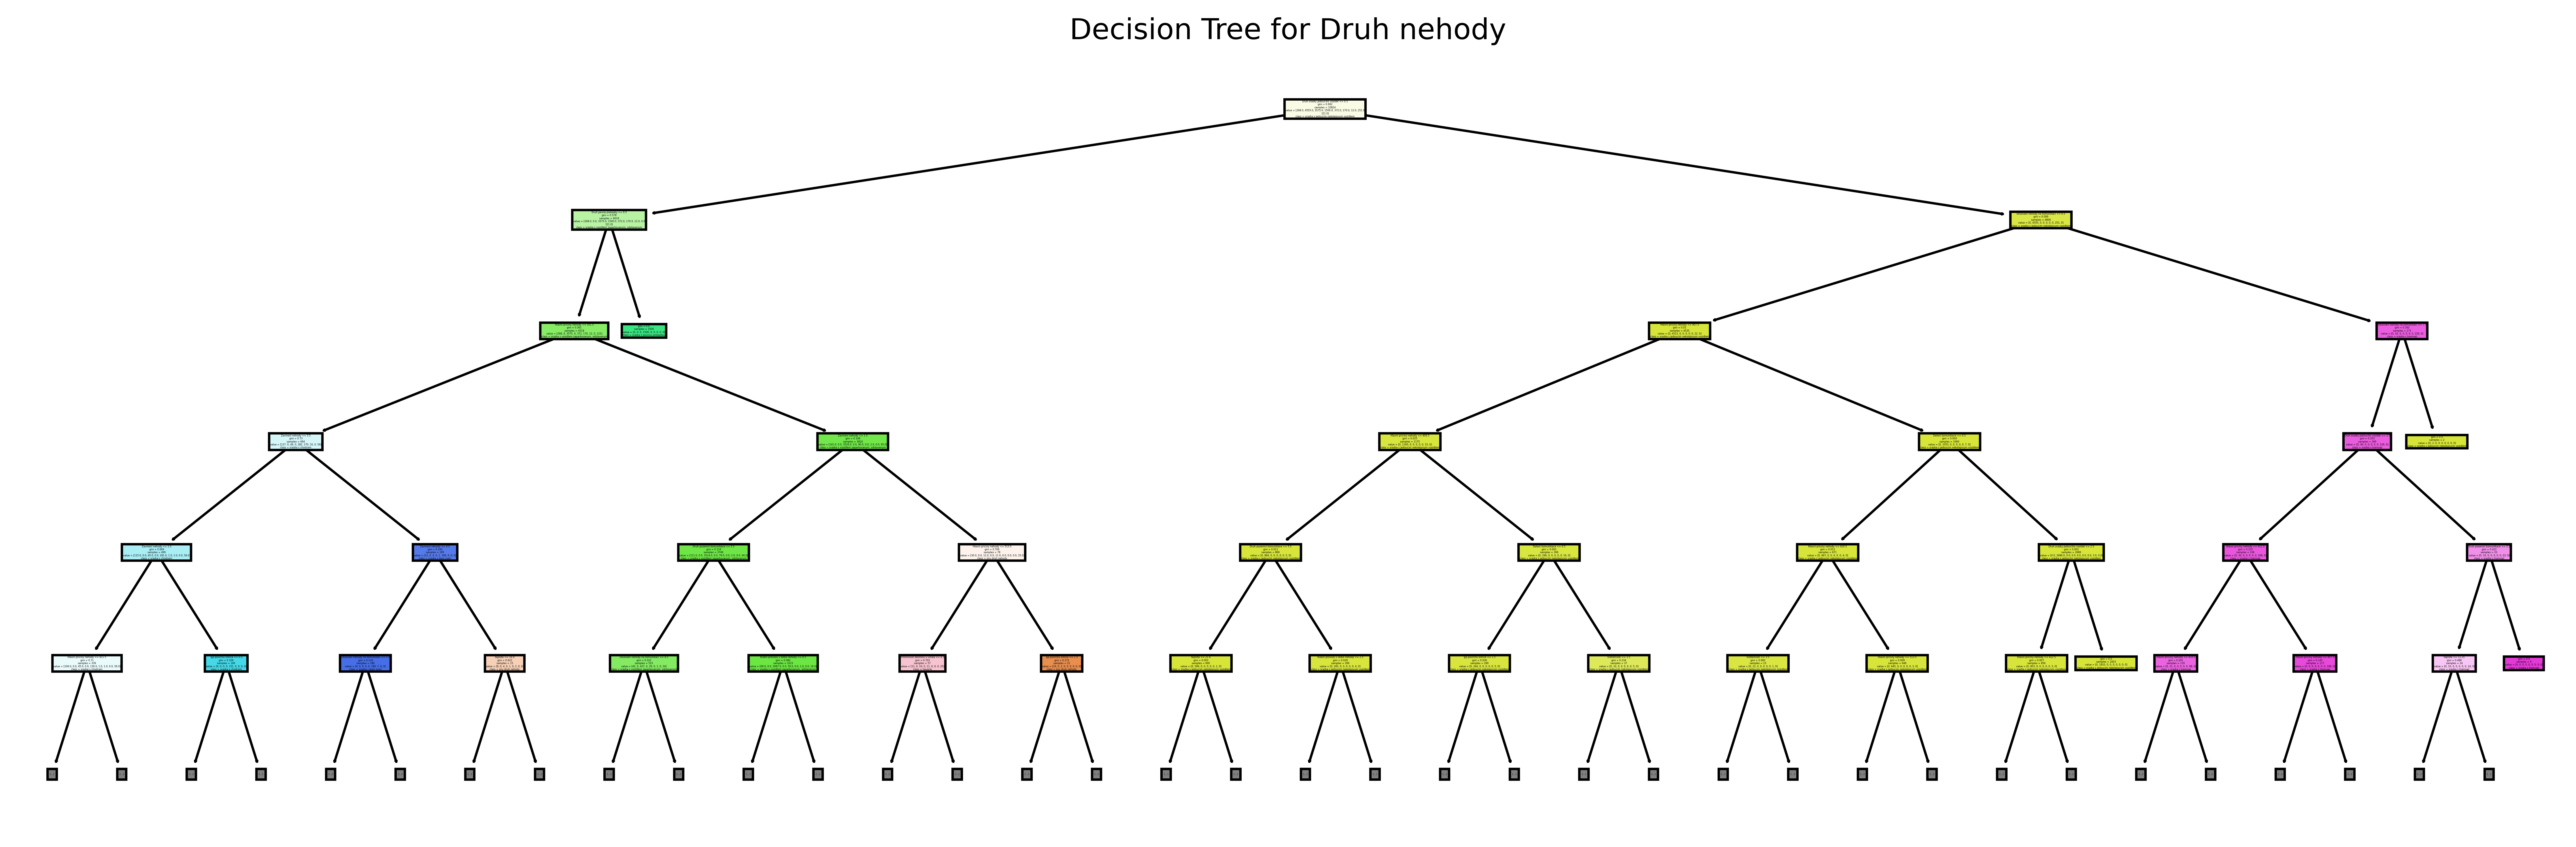

In [10]:

plt.figure(figsize=(15, 5), dpi=600)
for i, column in enumerate(y.columns, start=1):
    plt.subplot(1, len(y.columns), i)
    features = [dictionary.get(name, {}).get('label', name) for name in models[column].feature_names_in_]
    class_labels = [dictionary.get(column, {}).get('items',{}).get(str(label),label) for label in models[column].classes_]
    plot_tree(models[column], filled=True, feature_names=features, class_names=class_labels, max_depth=5)
    plt.title(f"Decision Tree for {dictionary.get(column,{}).get('label')}")
plt.tight_layout()
plt.show()

## Metaparameter tuning

In [11]:
from sklearn.model_selection import GridSearchCV

# max dephth columns + 1
param_grid = {
    'max_depth': range(1, X.shape[1] + 1),
    'min_samples_split': range(2, 15),
    'min_samples_leaf': range(1, 8)
}

best_models = {}

for column in y.columns:
    clf = DecisionTreeClassifier()
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train[column])
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train[column])
    best_models[column] = best_model

print(best_models)

best_accuracies = {}
for column in y.columns:
    y_pred = best_models[column].predict(X_test)
    best_accuracies[column] = accuracy_score(y_test[column], y_pred)
    print(f"Best accuracy for {dictionary.get(column,{}).get('label')}: {best_accuracies[column]}")


{'p6': DecisionTreeClassifier(max_depth=9, min_samples_split=8)}
Best accuracy for Druh nehody: 0.9573183875835309


## Manually test models

In [12]:
# Test
translate_and_print_example(models=models, example=X_test.iloc[160])
translate_and_print_example(models=models, example=X_test.iloc[161])
translate_and_print_example(models=models, example=X_test.iloc[300])
translate_and_print_example(models=models, example=X_test.iloc[600])

4338: >>
Lokalita nehody: v obci
Druh srazky jedouciho vozidel: neprichazi v uvahu - nejedna se o srazku jedoucich vozidel
Druh pevne prekazky: nepříchází v úvahu (nejedná se o srážku s pevnou překážkou)
Zavineni nehody: řidičem motorového vozidla
Pritomnost alkoholu u vinika: Ne
Hlavni priciny nehody: vyhýbání bez dostatečného bočního odstupu (vůle)
Typ povrchu silnice: živice
Stav povrchu vozovky v dobe nehody: povrch suchý neznečištěný
Stav komunikace: dobrý, bez závad
Povetrnostni podminky v dobe nehody: neztížené
Viditelnosti: ve dne, viditelnost nezhoršená vlivem povětrnostních podmínek
Rozhledove podminky: dobré
Deleni komunikace: dvoupruhová
Situovani nehody na komunikaci: žádné z uvedených
Rizeni provozu v dobe nehody: žádný způsob řízení provozu
Smerove pomery: přímý úsek
Druh pozemni komunikace: komunikace mistni
teplota: 9.5
Prediction: srazka s vozidlem zaparkovanym, odstavenym  <<
2088: >>
Lokalita nehody: v obci
Druh srazky jedouciho vozidel: neprichazi v uvahu - nejedna

/Users/luckykiet/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/luckykiet/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/luckykiet/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/luckykiet/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
